In [410]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [411]:
stocks = pd.read_csv('stocks_clean/AAPL.csv', parse_dates=['date_'])

In [412]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10569 entries, 0 to 10568
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date_   10569 non-null  datetime64[ns]
 1   ticker  10569 non-null  object        
 2   open    10569 non-null  float64       
 3   high    10569 non-null  float64       
 4   low     10569 non-null  float64       
 5   close   10569 non-null  float64       
 6   vol     10569 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 578.1+ KB


In [413]:
stocks.head()

,date_,ticker,open,high,low,close,vol
0,2015-01-02 17:00:00,AAPL,111.390,111.44,108.650,109.5000,9886884
1,2015-01-02 18:00:00,AAPL,109.490,109.71,107.350,108.2850,12628997
2,2015-01-02 19:00:00,AAPL,108.290,108.79,107.850,108.7761,6291776
3,2015-01-02 20:00:00,AAPL,108.770,109.59,108.755,109.3550,5049924
4,2015-01-02 21:00:00,AAPL,109.355,109.47,108.750,108.9900,3663606


In [414]:
sample = stocks[:900].copy()

In [415]:
sample.head(10)

,date_,ticker,open,high,low,close,vol
0,2015-01-02 17:00:00,AAPL,111.390,111.440,108.650,109.5000,9886884
1,2015-01-02 18:00:00,AAPL,109.490,109.710,107.350,108.2850,12628997
2,2015-01-02 19:00:00,AAPL,108.290,108.790,107.850,108.7761,6291776
3,2015-01-02 20:00:00,AAPL,108.770,109.590,108.755,109.3550,5049924
4,2015-01-02 21:00:00,AAPL,109.355,109.470,108.750,108.9900,3663606
5,2015-01-02 22:00:00,AAPL,108.995,109.380,108.900,109.0800,3071880
6,2015-01-02 23:00:00,AAPL,109.080,109.524,108.690,109.3000,6452430
7,2015-01-05 17:00:00,AAPL,108.290,108.650,107.410,107.5746,7957798
8,2015-01-05 18:00:00,AAPL,107.570,108.190,107.330,107.4200,7674767
9,2015-01-05 19:00:00,AAPL,107.425,107.530,106.550,106.8733,8600950


In [416]:
def plot_timeseries(data_set, vals, period='1M'):
    date_range = pd.date_range(start=data_set.iloc[:, 0].min(), end=data_set.iloc[:, 0].max(), freq=period)
    with plt.style.context('seaborn-notebook'):
        fig, ax = plt.subplots()
        
        plt.plot(data_set.columns[0], f'{vals}', data=data_set)
        ax.set_xlabel("Date")
        ax.xaxis.set_major_formatter(DateFormatter(f'%Y-%m'))
        plt.xticks(date_range)

In [417]:
def exp_smoothing(series, alpha=0.05):
    smoothed = [series[0]]
    for i in range(1, len(series)):
        smoothed.append(alpha*series[i] + (1-alpha) * series[i-1])
    return smoothed

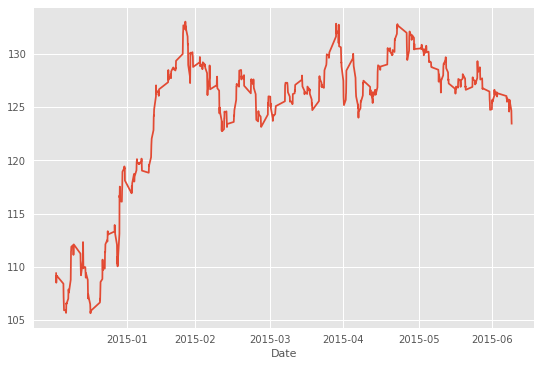

In [418]:
sample['test'] = exp_smoothing(sample.close, 0.5)
plot_timeseries(sample, 'test')

In [419]:
sample.test.head()

0    109.50000
1    108.89250
2    108.53055
3    109.06555
4    109.17250
Name: test, dtype: float64

CPU times: total: 78.1 ms
Wall time: 65 ms


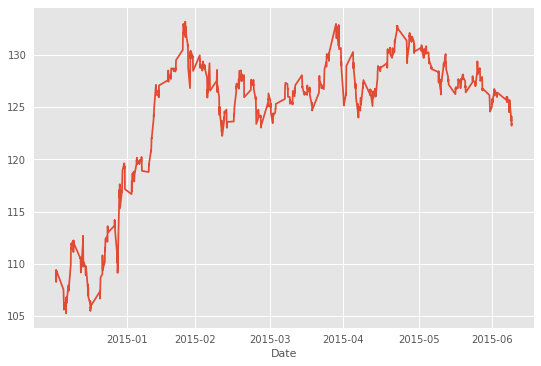

In [420]:
%%time
plot_timeseries(sample, 'close', '1M')


In [421]:
sample.head()

,date_,ticker,open,high,low,close,vol,test
0,2015-01-02 17:00:00,AAPL,111.390,111.44,108.650,109.5000,9886884,109.50000
1,2015-01-02 18:00:00,AAPL,109.490,109.71,107.350,108.2850,12628997,108.89250
2,2015-01-02 19:00:00,AAPL,108.290,108.79,107.850,108.7761,6291776,108.53055
3,2015-01-02 20:00:00,AAPL,108.770,109.59,108.755,109.3550,5049924,109.06555
4,2015-01-02 21:00:00,AAPL,109.355,109.47,108.750,108.9900,3663606,109.17250


### Stationarity

<Figure size 576x396 with 0 Axes>

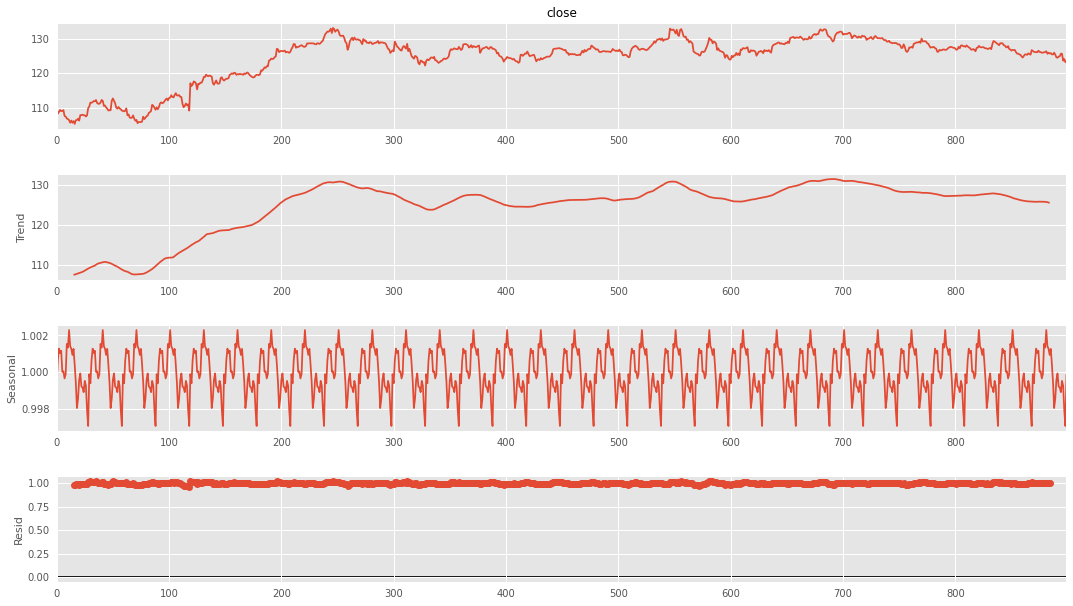

In [422]:
result = seasonal_decompose(sample['close'], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [423]:
sample['close_log'] = np.log(sample.close)


<Figure size 576x396 with 0 Axes>

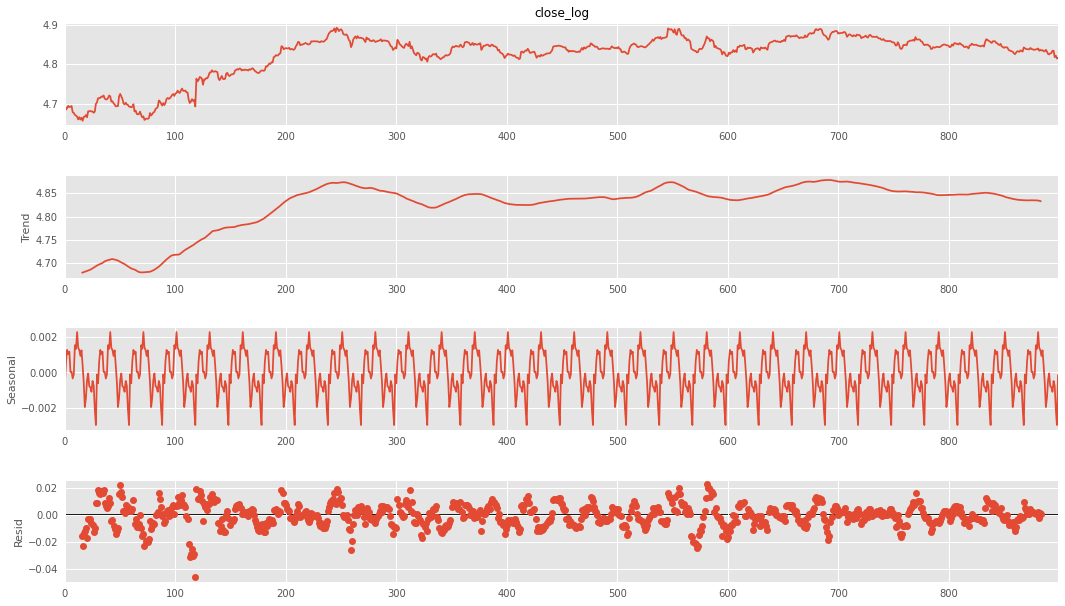

In [424]:
result = seasonal_decompose(sample['close_log'], model='additive', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [425]:
print( 'Results of Dickey-Fuller Test:')
dftest = adfuller(sample['close_log'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print(dfoutput) 

Results of Dickey-Fuller Test:
Test Statistic                  -2.476152
p-value                          0.121385
#Lags Used                       1.000000
Number of Observations Used    898.000000
Critical Value (1%)             -3.437653
Critical Value (5%)             -2.864764
Critical Value (10%)            -2.568487
dtype: float64


In [426]:
def first_difference(series):
    diffs = [0]
    for i in range(1, len(series)):
        diffs.append(series[i]-series[i-1])
    return pd.Series(diffs)

### ARIMA

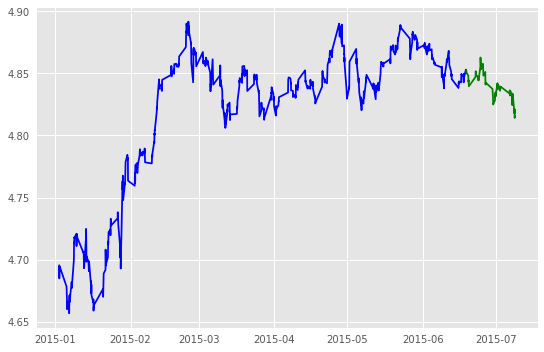

In [427]:
split_point = int(len(sample)*0.9)
train, test = sample[:split_point], sample[split_point:]
plt.plot(train.columns[0], 'close_log', data=train, color='blue')
plt.plot(test.columns[0], 'close_log', data=test, color='green')

In [428]:
model_autoARIMA = auto_arima(train['close_log'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6123.750, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6127.163, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6126.864, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6124.779, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6125.745, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6126.023, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6123.892, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6128.007, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6126.656, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6126.921, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6127.705, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6124.868, Time=0.19 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.436 seconds
                               SARIMAX Results                              

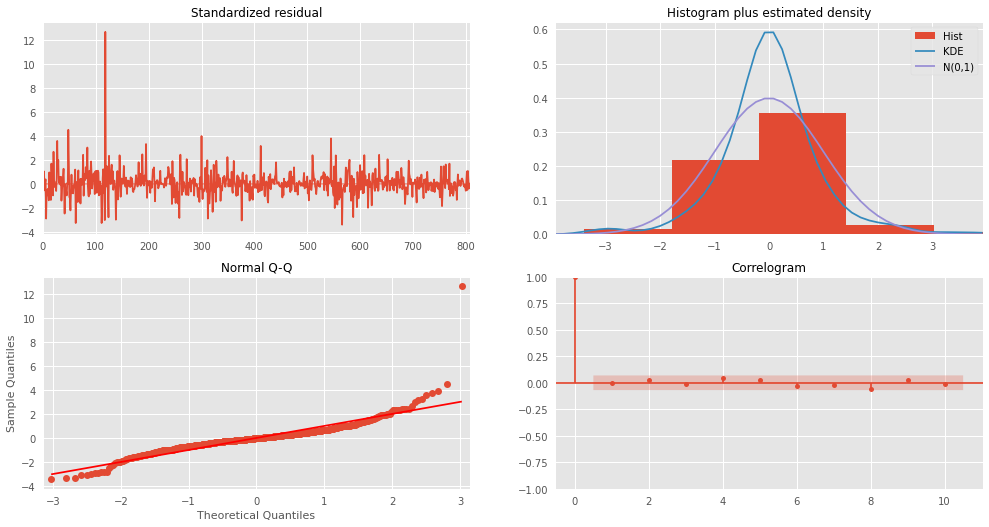

In [429]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [430]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['close_log'], order=(1,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              close_log   No. Observations:                  810
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3066.003
Date:                Thu, 21 Apr 2022   AIC                          -6128.007
Time:                        07:19:00   BIC                          -6118.615
Sample:                             0   HQIC                         -6124.401
                                - 810                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0801      0.037     -2.144      0.032      -0.153      -0.007
sigma2      2.985e-05      6e-07     49.719      0.000    2.87e-05     3.1e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [431]:
fitted.forecast(321, alpha=0.05)

810     4.849665
811     4.849654
812     4.849655
813     4.849655
814     4.849655
          ...   
1126    4.849655
1127    4.849655
1128    4.849655
1129    4.849655
1130    4.849655
Name: predicted_mean, Length: 321, dtype: float64

In [432]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

NameError: name 'fc' is not defined